## Prepare Dataset

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
print(tf.__version__)

2.5.0


In [2]:
! pip install -q kaggle

In [3]:
# upload your token from kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"fandisyamsudin","key":"15263541ec7ec2cd7938990ceda27c01"}'}

In [4]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [6]:
!kaggle datasets download -d piaoya/plastic-recycling-codes
!unzip plastic-recycling-codes

plastic-recycling-codes.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  plastic-recycling-codes.zip
  inflating: seven_plastics/1_polyethylene_PET/85943598-ec9b-4da5-9221-8c32b5742e72.jpg  
  inflating: seven_plastics/1_polyethylene_PET/AORA7148.jpg  
  inflating: seven_plastics/1_polyethylene_PET/BBOZ2526.jpg  
  inflating: seven_plastics/1_polyethylene_PET/BIGI9753.jpg  
  inflating: seven_plastics/1_polyethylene_PET/FQCK7421.jpg  
  inflating: seven_plastics/1_polyethylene_PET/HSBT4561.jpg  
  inflating: seven_plastics/1_polyethylene_PET/IMG_6263.jpg  
  inflating: seven_plastics/1_polyethylene_PET/IMG_6268.jpg  
  inflating: seven_plastics/1_polyethylene_PET/IMG_6269.jpg  
  inflating: seven_plastics/1_polyethylene_PET/IMG_6271.jpg  
  inflating: seven_plastics/1_polyethylene_PET/IMG_6272.jpg  
  inflating: seven_plastics/1_polyethylene_PET/IMG_6308.jpg  
  inflating: seven_plastics/1_polyethylene_PET/IMG_6328.jpg  
  inflating: seve

In [10]:
BATCH_SIZE = 32
IMG_SIZE = (224, 224)
IMG_DIR = ('../content/seven_plastics/')

## PreProcessing Dataset

In [14]:
train_dataset = image_dataset_from_directory(
    IMG_DIR,
    shuffle=True,
    validation_split=0.2,
    subset='training',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    seed = 21
)

Found 685 files belonging to 8 classes.
Using 548 files for training.


In [15]:
validation_dataset = image_dataset_from_directory(
    IMG_DIR,
    shuffle=True,
    validation_split=0.2,
    subset='validation',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    seed = 21
)

Found 685 files belonging to 8 classes.
Using 137 files for validation.


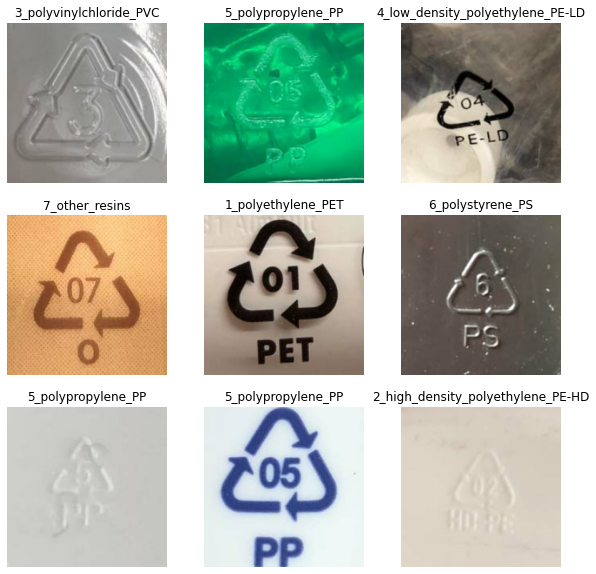

In [16]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, 1+i)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


In [19]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
  tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
  tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
  tf.keras.layers.experimental.preprocessing.RandomHeight(0.2),
  tf.keras.layers.experimental.preprocessing.RandomWidth(0.2),
])


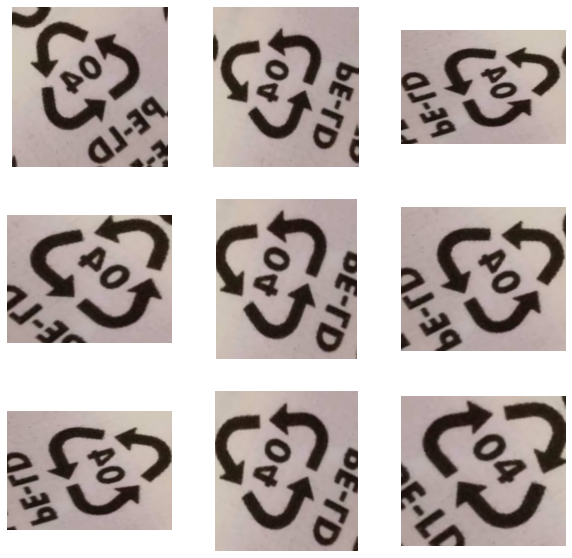

In [20]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')


In [21]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)

In [23]:
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)

## Build Model

In [24]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.EfficientNetB0(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

16711680/16705208 [==============================] - 0s 0us/step


In [25]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 7, 7, 1280)


In [26]:
base_model.trainable = False

In [27]:
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling_1 (Rescaling)         (None, 224, 224, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 224, 224, 3)  7           rescaling_1[0][0]                
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 225, 225, 3)  0           normalization[0][0]              
_____________________________________________________________________________________

In [28]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [29]:
num_classes = len(class_names)
prediction_layer = tf.keras.layers.Dense(num_classes)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)


(32, 8)


In [31]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)


In [32]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, None, None, 3)     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, 7, 7, 1280)        4049571   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 8)                 10248     
Total params: 4,059,819
Trainable params: 10,248
Non-trainable params: 4,049,571
______________________________________________

In [34]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [36]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, None, None, 3)     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, 7, 7, 1280)        4049571   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 8)                 10248     
Total params: 4,059,819
Trainable params: 10,248
Non-trainable params: 4,049,571
______________________________________________

In [38]:
initial_epochs = 5

loss0, accuracy0 = model.evaluate(validation_dataset)


5/5 [==============================] - 0s 66ms/step - loss: 2.1273 - accuracy: 0.2117


In [39]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)


Epoch 1/5
18/18 [==============================] - 12s 345ms/step - loss: 2.0518 - accuracy: 0.2099 - val_loss: 2.0389 - val_accuracy: 0.2482
Epoch 2/5
18/18 [==============================] - 7s 366ms/step - loss: 1.9720 - accuracy: 0.2372 - val_loss: 1.9752 - val_accuracy: 0.2774
Epoch 3/5
18/18 [==============================] - 7s 363ms/step - loss: 1.9081 - accuracy: 0.2609 - val_loss: 1.9239 - val_accuracy: 0.2993
Epoch 4/5
18/18 [==============================] - 6s 334ms/step - loss: 1.8584 - accuracy: 0.3102 - val_loss: 1.8852 - val_accuracy: 0.3139
Epoch 5/5
18/18 [==============================] - 5s 254ms/step - loss: 1.7963 - accuracy: 0.3376 - val_loss: 1.8527 - val_accuracy: 0.3504


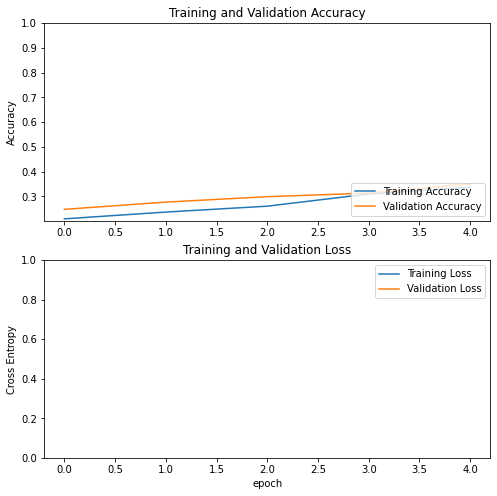

In [40]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


## Fine Tune Model

In [41]:
base_model.trainable = True

In [42]:
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  237


In [43]:
fine_tune_at = 50
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False


In [44]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [45]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, None, None, 3)     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, 7, 7, 1280)        4049571   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 8)                 10248     
Total params: 4,059,819
Trainable params: 3,994,962
Non-trainable params: 64,857
______________________________________________

## Training Model

In [46]:
fine_tune_epochs = 20
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)


Epoch 5/25
18/18 [==============================] - 25s 744ms/step - loss: 1.7647 - accuracy: 0.3577 - val_loss: 1.7753 - val_accuracy: 0.3431
Epoch 6/25
18/18 [==============================] - 9s 510ms/step - loss: 1.6977 - accuracy: 0.3960 - val_loss: 1.7332 - val_accuracy: 0.3504
Epoch 7/25
18/18 [==============================] - 9s 496ms/step - loss: 1.6228 - accuracy: 0.4252 - val_loss: 1.6964 - val_accuracy: 0.3869
Epoch 8/25
18/18 [==============================] - 9s 522ms/step - loss: 1.5736 - accuracy: 0.4288 - val_loss: 1.6610 - val_accuracy: 0.3869
Epoch 9/25
18/18 [==============================] - 7s 401ms/step - loss: 1.5503 - accuracy: 0.4489 - val_loss: 1.6334 - val_accuracy: 0.4161
Epoch 10/25
18/18 [==============================] - 8s 460ms/step - loss: 1.5057 - accuracy: 0.4599 - val_loss: 1.5998 - val_accuracy: 0.4307
Epoch 11/25
18/18 [==============================] - 7s 370ms/step - loss: 1.4509 - accuracy: 0.5000 - val_loss: 1.5736 - val_accuracy: 0.4599
Epo

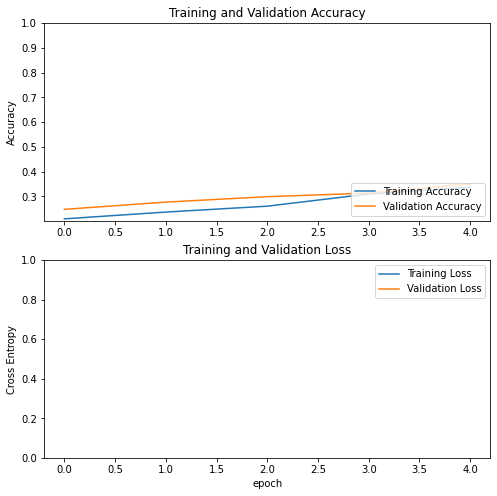

In [47]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


In [48]:
fine_tune_epochs_2 = 100
total_epochs =  initial_epochs + fine_tune_epochs + fine_tune_epochs_2

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)


Epoch 5/125
18/18 [==============================] - 7s 362ms/step - loss: 0.9975 - accuracy: 0.6734 - val_loss: 1.2856 - val_accuracy: 0.5766
Epoch 6/125
18/18 [==============================] - 6s 333ms/step - loss: 0.9789 - accuracy: 0.6807 - val_loss: 1.2665 - val_accuracy: 0.5620
Epoch 7/125
18/18 [==============================] - 6s 305ms/step - loss: 0.9547 - accuracy: 0.6953 - val_loss: 1.2591 - val_accuracy: 0.5474
Epoch 8/125
18/18 [==============================] - 6s 299ms/step - loss: 0.9098 - accuracy: 0.7117 - val_loss: 1.2477 - val_accuracy: 0.5474
Epoch 9/125
18/18 [==============================] - 6s 291ms/step - loss: 0.8926 - accuracy: 0.7172 - val_loss: 1.2310 - val_accuracy: 0.5401
Epoch 10/125
18/18 [==============================] - 5s 277ms/step - loss: 0.8870 - accuracy: 0.7044 - val_loss: 1.2345 - val_accuracy: 0.5693
Epoch 11/125
18/18 [==============================] - 5s 250ms/step - loss: 0.8486 - accuracy: 0.7099 - val_loss: 1.2149 - val_accuracy: 0.58

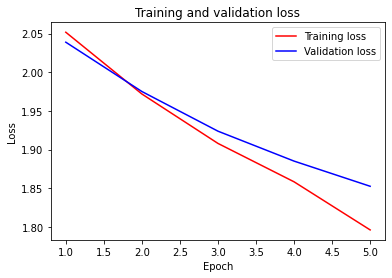

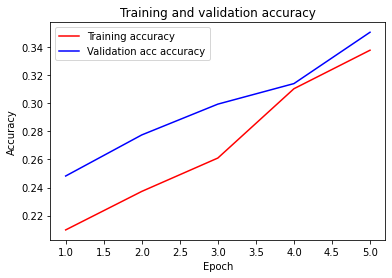

<Figure size 432x288 with 0 Axes>

In [57]:
# display the curves

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + )

# curve loss
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.figure()

# curve accuracy
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation acc accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.figure()

plt.show()

## Evaluate Model

In [64]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

5/5 [==============================] - 0s 64ms/step - loss: 1.5029 - accuracy: 0.7299
Test accuracy : 0.7299270033836365


## Save Model

In [68]:
model.save('fandi-efficientnet-model')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: fandi-efficientnet-model/assets


## Convert to Json

In [69]:
# convert to json
import json
json_string = model.to_json()
f = open("../content/fandi-efficientnet-model.json", "w")
json.dump(json_string, f)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


## Convert to TFLite

In [70]:
# convert the model to TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
with open('fandi-efficientnet-model.tflite', 'wb') as f:
  f.write(tflite_model)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /tmp/tmpfm5c65cn/assets


In [ ]:
# create labels 
labels = '\n'.join(sorted(train_dataset.class_indices.keys()))
with open('labels.txt', 'w') as f:
  f.write(labels)

## Save to Bucket on GCP

In [75]:
# Authentic Colab 
# (running this will give you a code to authentic your Google Colab instance, keep the code secret)
from google.colab import auth
auth.authenticate_user()

In [76]:
# Install and initialize the gcloud command line tool - https://cloud.google.com/sdk/docs/install
# (this will give you access to gcloud tools within Colab)
!curl https://sdk.cloud.google.com | bash 1> /dev/null
!gcloud init

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   443  100   443    0     0  19260      0 --:--:-- --:--:-- --:--:-- 19260
######################################################################## 100.0%
which curl
curl -# -f https://dl.google.com/dl/cloudsdk/channels/rapid/google-cloud-sdk.tar.gz
######################################################################## 100.0%
mkdir -p /root
tar -C /root -zxvf /tmp/tmp.19tU99QGCL/google-cloud-sdk.tar.gz
/root/google-cloud-sdk/install.sh
Beginning update. This process may take several minutes.


Your current Cloud SDK version is: 342.0.0
Installing components from version: 342.0.0

┌─────────────────────────────────────────────────────────────────────────────┐
│                     These components will be installed.                     │
├─────────────────────────────────────────────────────┬────────────┬──────────┤
│        

In [77]:
# Copy model to bucket - https://cloud.google.com/storage/docs/uploading-objects#gsutil 
# Use "-r" for folders (r stands for recursive)
!gsutil cp -r fandi-efficientnet-model gs://go-bin-capstone

Copying file://fandi-efficientnet-model/keras_metadata.pb [Content-Type=application/octet-stream]...
Copying file://fandi-efficientnet-model/saved_model.pb [Content-Type=application/octet-stream]...
Copying file://fandi-efficientnet-model/variables/variables.data-00000-of-00001 [Content-Type=application/octet-stream]...
Copying file://fandi-efficientnet-model/variables/variables.index [Content-Type=application/octet-stream]...
/ [4 files][ 39.1 MiB/ 39.1 MiB]                                                
Operation completed over 4 objects/39.1 MiB.                                     


## The End